# Coupled SSA with elastic flexure
This notebook couples the modified SSA [(MacAyeal et al., 2021)](https://www.cambridge.org/core/journals/journal-of-glaciology/article/treatment-of-iceshelf-evolution-combining-flow-and-flexure/AD266BB055752B4DC817FEAAA86363A3) with the Kirchhoff plate equations, allowing the approach of a steady-state velocity field with elastic flexure. I do not yet attempt to incorporate viscous flexure. Beginning with a shelf in isostatic equilibrium with seawater, the workflow is as follows:

## Workflow


1) **Solve the SSA to obtain a velocity field**
    - the modified SSA of Equation 44 in MacAyeal et al. 
    - see my [modified SSA notebook](https://github.com/chrismiele/weird_flex/blob/main/modified_SSA_firedrake.ipynb)<br>
    <br>
2) **Adjust the surface elevation and basal elevation via dynamic thinning only**
    - assume *zero surface mass balance* (SMB will modify shelf geometry in Step 4)
    - dynamically thin the submarine and subaerial parts of the shelf separately
    - this allows us to track the dynamic evolution of surface and basal elevation without assuming equilibrium <br>
    <br>
3) **Solve the Kirchhoff equations to flex the shelf**
    - load relates to surface mass balance as outlined in my [Kirchhoff plate notebook](https://github.com/chrismiele/weird_flex/blob/main/kirchhoff_plate.ipynb) (see also Eq. 57 of MacAyeal et al.) <br>
    <br>
4) **Adjust geometry and return to (1)**
    - this is where we use SMB to modify surface elevation, via ```s = SMB + η``` (η the vertical deflection)
    - with no basal mass balance, ```b = b + η```
    
    
## Caveats
- Step 2 assumes that dynamic thinning causes the surface to fall and the base to rise. Is this necessarily the case when the shelf is not in equilibrium? 
- Step 3 is problematic and always causes the solver to freeze after ~10 iterations or so. I don't know why. Current workaround is to only solve for flexure every $N$ steps
- Does it make sense that we get two separate stress tensors that have nothing to do with one another? I.e., a viscous stress tensor calculable from the flow field, and an elastic stress tensor calculable from the vertical deflection?
- Also, one boring (and also maybe convenient??) takeaway is that iteratively solving for flexure is maybe not necessary. Solutions are very similar when I approach steady state via the SSA first, and then solve for flexure at the end of the workflow.
    
    

     

## Imports

In [1]:
from firedrake import *
import icepack
from icepack.calculus import sym_grad
import matplotlib.pyplot as plt
from operator import itemgetter
import tqdm

## Mesh, function spaces, trial and test functions

The shelf will be rectangular, with length ```Lx``` and width ```Ly```. Deflection will be solved over Argyris elements of order 5, and velocity will be solved over CG elements of order 2. 

In [2]:
nx, ny = 100, 50 #number of elements in x, y
Lx, Ly = 10000, 5000 #length, width in meters
mesh = RectangleMesh(nx, ny, Lx, Ly)
x, y = SpatialCoordinate(mesh)

Q1 = FunctionSpace(mesh, 'Argyris', 5) #Argyris elements for solving 4th order flexure problem
Q2 = FunctionSpace(mesh, 'CG', 2) #CG elements for icepack's prognostic solve, which does not appreciate Argyris elements
V = VectorFunctionSpace(mesh, 'CG', 2)  #CG elements for solving SSA problem
S = TensorFunctionSpace(mesh, 'DG', 1) #DG elements for interpolating tensors arising from the velocity field

η = Function(Q1) #deflection
w = TestFunction(Q1)
ddη = grad(grad(η)) 
ddw = grad(grad(w))
Δη = div(grad(η)) 
Δw = div(grad(w)) 

u = Function(V) #velocity
v = TestFunction(V) #note the Roman v, not to be confused with Greek ν introduced below

## Physical constants, shelf geometry

In [3]:
from icepack.constants import ice_density as ρ_I, water_density as ρ_W, gravity as G #note icepack's units on these
ρ_i = Constant(917) #ice density value consistent with icepack's, but in kg/m^3
ρ_w = Constant(1024) #water density consistent with icepack, but in kg/m^3
ϱ = Constant(ρ_i/ρ_w) #density ratio
g = Constant(9.81) #gravity in N/kg
E = Constant(1e11) #Young's Modulus in Pascals
μ = Constant(1/3) #Poisson's Ratio
λ_1 = Constant(E/(1 + μ)) #convenient shorthand variable
λ_2 = Constant(E/(1 + μ)*μ/(1 - μ)) #convenient shorthand variable
T = Constant(273.15) #temperature (K). 273.15 is freezing
A = icepack.rate_factor(T) #A from Glen's law
ν = Constant(1/2*A**(-1/3)) #ice viscosity (note the symbol Greek symbol ν)

H_gl = Constant(600) #thickness at upstream boundary (m)
thick_grad = -1e-3 #thickness gradient 
H0 = project(H_gl + thick_grad*x, Q2) #initial thickness projected onto CG elements
b0 = project(-ϱ*H0, Q2) #initial basal elevation
s0 = project(H0 + b0, Q2) #initial surface elevation

## Modify some icepack modules to solve non-equilibrium SSA

In [4]:
def gravity2(**kwargs): #see RHS of Eq. 44 in MacAyeal et al. (2021), but note the sign error!
    u, h, b = itemgetter('velocity', 'thickness', 'base')(kwargs)
    
    return -0.5* ρ_I*G*inner(grad(h**2), u) + 0.5*ρ_W*G* inner(grad(b**2), u)


def terminus2(**kwargs): #see Eq. 45 from MacAyeal et al. (2021)
    u, h, b = itemgetter('velocity', 'thickness', 'base')(kwargs)
    mesh = u.ufl_domain()
    ν = FacetNormal(mesh)
    
    return 0.5*ρ_I*G*h**2*inner(u, ν) - 0.5*ρ_W*G*b**2*inner(u, ν)


def deviatoric_stress(**kwargs): #and also define the deviatoric stress tensor
    n = 3
    e = itemgetter('strain_rate')(kwargs)
    e_min = Constant(kwargs.get('strain_rate_min', icepack.constants.strain_rate_min))
    e_e = icepack.models.viscosity._effective_strain_rate(e, e_min)
    
    ν = 1/2*A**(-1/n)*e_e**(1/n-1)
    return 2*ν*e

## Solver parameters

For now I'll just solve the simplest case of a shelf in longitudinal extension. This is achieved by assigning the lateral boundaries to be ```side_wall_ids``` with friction coefficient zero. The upstream boundary condition will be zero, which means that all motion will be due to the driving stress. 

Surface mass balance is chosen to melt out a lake in the shape of a Gaussian curve (see figure below). 

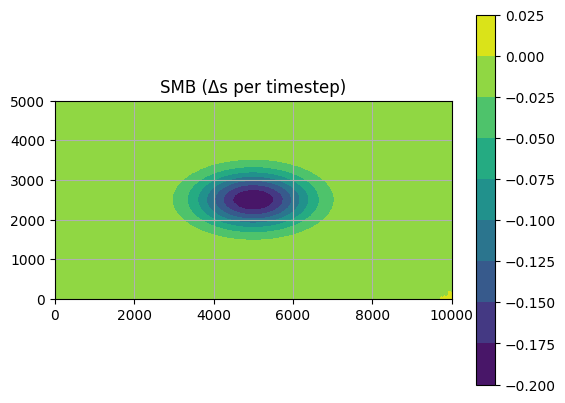

In [5]:
##################################
##################################
### parameters for flow solver ###
##################################
##################################

dirichlet_ids = [1]
side_wall_ids = [3, 4]
ice_front_ids = [2]

model = icepack.models.IceShelf(gravity = gravity2, terminus = terminus2,
                           side_friction = icepack.models.friction.side_friction)

solver = icepack.solvers.FlowSolver(model, dirichlet_ids = dirichlet_ids, 
                                    side_wall_ids = side_wall_ids, ice_front_ids = ice_front_ids)

u0 = project(as_vector([1e-50, 1e-50]), V) #initial velocity for imposing Dirichlet BCs
C0 = Constant(0.0) #coefficient of sidewall friction
dt = 1 #length of timestep in years
num_timesteps = 50
N = int(num_timesteps/10) #solve flexure every N timesteps

#####################################
#####################################
### parameters for flexure solver ###
#####################################
#####################################

α = 1e10 #arbitrary large number for penalty method
smb_x = 0.2*exp(-1/2*((x - Lx/2)/(0.1*Lx))**2) #impose some surface mass balance
smb_y = exp(-1/2*((y - Ly/2)/(0.1*Ly))**2) #we'll melt out a lake at the center of the shelf...
SMB = project(-smb_x*smb_y*dt, Q1) #...in the shape of a 3D gaussian curve

#plot the surface mass balance 
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.title('SMB (Δs per timestep)')
smb_plot = tricontourf(SMB, axes=ax)
plt.colorbar(smb_plot)
plt.grid()
plt.show()

## Iteratively solve the flow-flexure problem


In [6]:
u, H, s, b = u0.copy(deepcopy=True), H0.copy(deepcopy=True), s0.copy(deepcopy=True), b0.copy(deepcopy=True) #initialize params

for step in tqdm.trange(num_timesteps):
    
    #############################
    #############################
    ### get velocity solution ###
    #############################
    #############################
    
    u = solver.diagnostic_solve(velocity = u, side_friction = C0, thickness = H, base = b, fluidity = A)
    
    ##################################
    ##################################
    ### dynamically thin the shelf ###
    ##################################
    ##################################
    
    s = solver.prognostic_solve(dt, thickness = s, velocity = u, #lower the surface 
                           thickness_inflow = Constant((1 - ϱ)*H_gl), accumulation = Constant(0))
    
    b = solver.prognostic_solve(dt, thickness = b, velocity = u, #raise the base
                           thickness_inflow = Constant(-ϱ*H_gl), accumulation = Constant(0))
    
    ######################
    ######################
    ### flex the shelf ###
    ######################
    ######################
    
    if step%N == N - 1: #solve flexure every Nth timestep

        s_ = project(s, Q1) #project surface elevation over Argyris elements
        b_ = project(b, Q1) #and basal elevation
        H_ = project(s_ - b_, Q1) #and total thickness

        h_ab = s_ + SMB + η - (1 - ϱ)*H_ #height above buoyancy after flexure

        f = conditional(h_ab < 0, #if height above buoyancy is negative after flexing:
                        -ρ_w*g*h_ab, #f acts upward via buoyancy
                        -ρ_i*g*h_ab) #else: f acts downward via gravity

#         #leaving the flow contribution out for now because it seems to be ~3 orders of magnitude smaller than buoyancy
#         ux, uy = project(u[0], Q1), project(u[1], Q1) #velocity compenents will help force the flexure
#         f += H_*(4*ν*grad(ux)[0] + 2*ν*grad(uy)[0] - 1/2*ρ_i*g*H_)*ddη[0, 0] #Eq. 57e: ice shelf flow contribution 
#         f += H_*(ν*grad(ux)[1] + ν*grad(uy)[0])*ddη[0, 1] #Eq. 57e continued
#         f += H_*(2*ν*grad(ux)[0] + 4*ν*grad(uy)[1] - 1/2*ρ_i*g*H_)*ddη[1, 1] #Eq. 57e continued

        L = (λ_1*(H_**3)/12*inner(ddη, ddw))*dx + λ_2*(H_**3)/12*Δη*Δw*dx - f*w*dx #the flexure equation
        L += 0.5*α**2*(η*w)*ds(1) #constrain η = 0 on boundary 1 via penalty method
        L += 0.5*α**2*(η*w)*ds(3) #η = 0 on boundary 3
        L += 0.5*α**2*(η*w)*ds(4) #η = 0 on boundary 4

        solve(L == 0, η)

    #######################
    #######################
    ### adjust geometry ###
    #######################
    #######################
    
    #still under the conditional here:
    
        b = project(b + η, Q2) #b is modified by the deflection
        s = project(s + SMB + η, Q2) #s is modified by deflection and surface mass balance
        
    else:
        s = project(s + SMB, Q2) #if we haven't solved for flexure this step, only modify s by surface mass balance
        #b remains the same
    
    H = project(s - b, Q2) #in either case, H = s - b


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [01:31<00:00,  1.83s/it]


## Plot solutions

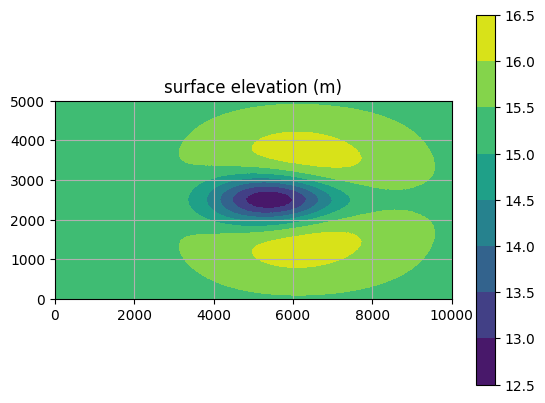

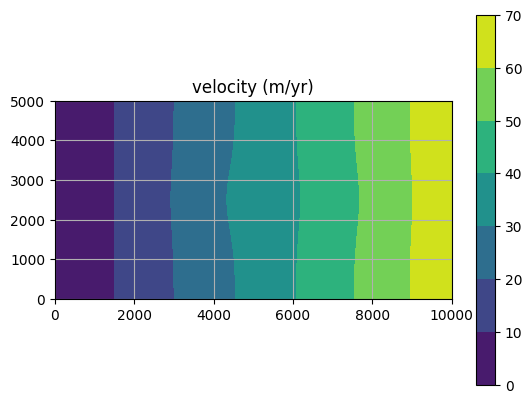

In [7]:
fig, ax = plt.subplots() 
ax.set_aspect('equal')
plt.title('surface elevation (m)')
elev_plot = tricontourf(project(s, Q1), axes=ax)
plt.colorbar(elev_plot)
plt.grid()
plt.show()

fig, ax = plt.subplots() 
ax.set_aspect('equal')
plt.title('velocity (m/yr)')
vel_plot = tricontourf(u, axes=ax)
plt.colorbar(vel_plot)
plt.grid()
plt.show()

## Postprocessing

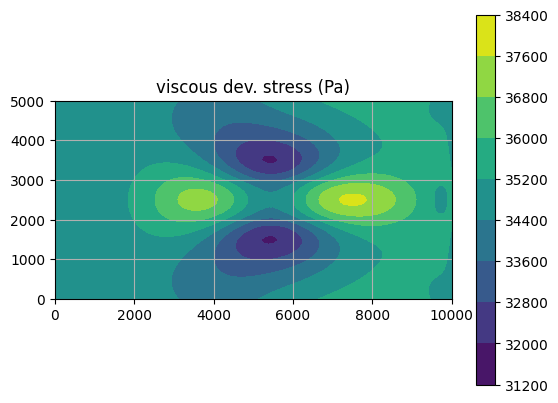

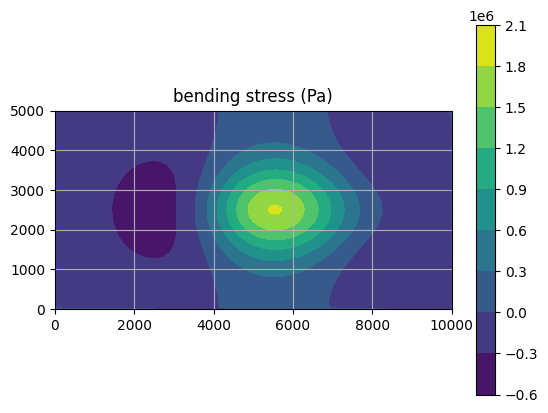

In [8]:
########################
########################
### viscous stresses ###
########################
########################

ε = Function(S)
ε.project(sym(grad(u)))
τ = deviatoric_stress(strain_rate = ε)
τxx = project(τ[0, 0]*1e6, Q2)

fig, ax = plt.subplots() 
ax.set_aspect('equal')
plt.title('viscous dev. stress (Pa)')
stress_plot = tricontourf(τxx, axes=ax)
plt.colorbar(stress_plot)
plt.grid()
plt.show()

########################
########################
### elastic stresses ###
########################
########################

σ_surf = -1/2*λ_1*H_*ddη - 1/2*λ_2*H_*tr(ddη)*Identity(2) #stress tensor at the surface (ζ = H/2)
σxx = project(σ_surf[0, 0], Q1)

fig, ax = plt.subplots() 
ax.set_aspect('equal')
plt.title('bending stress (Pa)')
stress_plot = tricontourf(σxx, axes=ax)
plt.colorbar(stress_plot)
plt.grid()
plt.show()

## Which load contributions can we neglect?

Investigate the relative importance of different load contributions in Step 3 (solving the flexure equations). Below, ```f1``` will be the load contribution from the surface mass balance (essentially Eq. 57a and 57c), and ```f2``` will be the load contribution from the velocity field (Eq. 57e). Because ```f2``` is so much smaller than ```f1```, I've justified excluding it from the iterations above. 

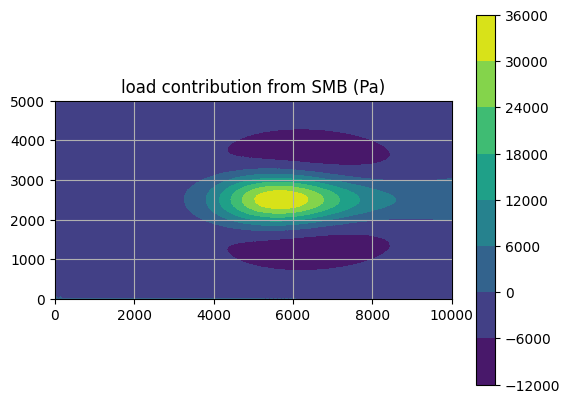

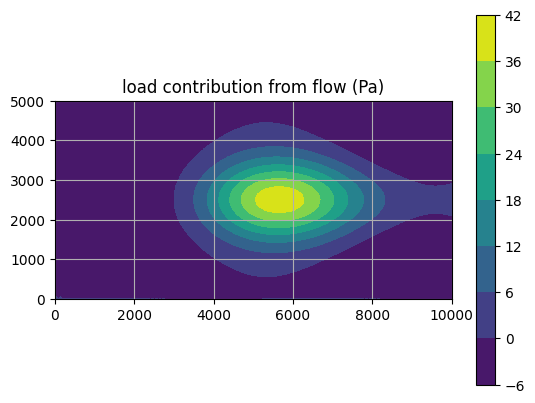

In [9]:
f1 = project(f, Q1)

ux, uy = project(u[0], Q1), project(u[1], Q1)
f2 = H_*(4*ν*grad(ux)[0] + 2*ν*grad(uy)[0] - 1/2*ρ_i*g*H_)*ddη[0, 0] #Eq. 57e: ice shelf flow contribution 
f2 += H_*(ν*grad(ux)[1] + ν*grad(uy)[0])*ddη[0, 1] #Eq. 57e continued
f2 += H_*(2*ν*grad(ux)[0] + 4*ν*grad(uy)[1] - 1/2*ρ_i*g*H_)*ddη[1, 1] #Eq. 57e continued
f2 = project(f2, Q1)

fig, ax = plt.subplots() 
ax.set_aspect('equal')
plt.title('load contribution from SMB (Pa)')
elev_plot = tricontourf(f1, axes=ax)
plt.colorbar(elev_plot)
plt.grid()
plt.show()

fig, ax = plt.subplots() 
ax.set_aspect('equal')
plt.title('load contribution from flow (Pa)')
vel_plot = tricontourf(f2, axes=ax)
plt.colorbar(vel_plot)
plt.grid()
plt.show()